# Predicting ADT Utilizing Multimodal Diagonal Cross-Generation

Jude Nogotey

#Introduction

This challenge requires us to train an AI model that can independently learn about information from multimodal single-cell sequencing data and use information from one modality to predict the other. In this challenge, data from single-cell ADT and RNA sequencing is used. In this type of sequencing, a tissue sample such as blood is dissociated into a suspension of individual cells which are then passed through a sequencer one by one. In each cell, the expression of all genes (RNA transcripts) can be measured, and the abundance of antibodies binding to target proteins can also be simultaneously measured (antibody-derived tags, ADT). This gives a matrix where rows are RNA or ADT features and columns are single cells. Because RNA makes protein in our cells, there are inherent relationships between RNA and protein, but also differences.
The task is to predict ADT for the corresponding test RNA samples while your model never jointly encounters RNA and ADT

# **Approach**

## Dataset Description
Datasets given for this challenge include training data from the RNA modality, train_rna.csv (5000 samples, 10000 features), training data from different samples in the ADT modality, train_adt.csv (5000 samples, 25 features), and test data from the RNA modality, test_rna.csv (2000 samples, 10000 features). In addition, there is an "evaluation" data from the RNA and ADT modalities, eval_rna.csv and eval_adt.csv (1000 samples, 10000 features in RNA, 25 features in ADT) that can be used to evaluate multimodal prediction but may not train on it.

## General Steps Taken to Implement Models to Solve Challenge
- Load the training data for the RNA and ADT modalities.

- Define the architecture of the AI model.

- Implement the training loop to train the model.

- Load the test data for the RNA modality.

- Use the trained model to predict ADT for the test RNA samples.

## Set-up

In [ ]:
# Loading Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
# Loading Data
train_rna = pd.read_csv('train_RNA.csv')
train_adt = pd.read_csv('train_ADT.csv')
test_rna = pd.read_csv('test_RNA.csv')


### Implementation of Models

### Model 1 - Multimodal Fusion Autoencoder

The provided code below implements a Multimodal Fusion Autoencoder (MFAE) for learning representations from both RNA and ADT modalities. It first preprocesses the input data, scaling it using MinMaxScaler and converting it into PyTorch tensors. The MFAE architecture consists of separate encoder layers for each modality, followed by a shared decoder layer. The model is trained using binary cross-entropy loss and Kullback-Leibler divergence loss for each modality's latent representation. The training loop runs for a specified number of epochs, optimizing the model parameters with the Adam optimizer. Additionally, the code calculates and tracks both training and validation loss to monitor model performance over epochs. Finally, it visualizes the training and validation loss using matplotlib to assess model convergence and generalization. This model provided a best kaggle score of **0.6951** after several hyperparameter tuning.

Epoch 1/50, Train Loss: 3210.8234, Val Loss: 1733.3581
Epoch 2/50, Train Loss: 1652.8761, Val Loss: 1634.1564
Epoch 3/50, Train Loss: 1600.4052, Val Loss: 1604.3837
Epoch 4/50, Train Loss: 1577.5167, Val Loss: 1591.5661
Epoch 5/50, Train Loss: 1564.2649, Val Loss: 1574.7571
Epoch 6/50, Train Loss: 1555.3680, Val Loss: 1566.6702
Epoch 7/50, Train Loss: 1546.5029, Val Loss: 1559.1257
Epoch 8/50, Train Loss: 1540.9167, Val Loss: 1552.5909
Epoch 9/50, Train Loss: 1535.0678, Val Loss: 1548.7781
Epoch 10/50, Train Loss: 1530.0649, Val Loss: 1546.8207
Epoch 11/50, Train Loss: 1525.7858, Val Loss: 1539.9624
Epoch 12/50, Train Loss: 1521.7918, Val Loss: 1536.5542
Epoch 13/50, Train Loss: 1518.4904, Val Loss: 1532.6194
Epoch 14/50, Train Loss: 1515.6192, Val Loss: 1529.8726
Epoch 15/50, Train Loss: 1512.2088, Val Loss: 1527.7011
Epoch 16/50, Train Loss: 1509.8505, Val Loss: 1526.8029
Epoch 17/50, Train Loss: 1508.3015, Val Loss: 1525.0985
Epoch 18/50, Train Loss: 1506.3614, Val Loss: 1523.9096
E

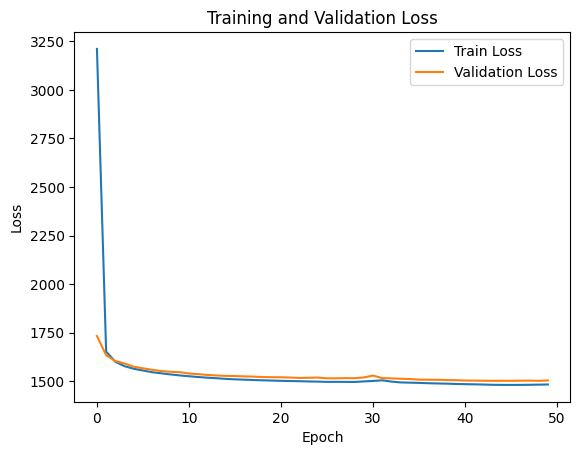

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the Multimodal Fusion Autoencoder class
class MultimodalFusionAE(nn.Module):
    def __init__(self, input_dim_rna, input_dim_adt, encoding_dim):
        super(MultimodalFusionAE, self).__init__()
        # Encoder layers for RNA modality
        self.fc1_rna = nn.Linear(input_dim_rna, 128)
        self.fc21_rna = nn.Linear(128, encoding_dim)
        self.fc22_rna = nn.Linear(128, encoding_dim)
        # Encoder layers for ADT modality
        self.fc1_adt = nn.Linear(input_dim_adt, 128)
        self.fc21_adt = nn.Linear(128, encoding_dim)
        self.fc22_adt = nn.Linear(128, encoding_dim)
        # Decoder layers
        self.fc3 = nn.Linear(2*encoding_dim, 128)
        self.fc4 = nn.Linear(128, input_dim_rna + input_dim_adt)  # Concatenate RNA and ADT data

    def encode(self, x_rna, x_adt):
        h1_rna = torch.relu(self.fc1_rna(x_rna))
        mu_rna, logvar_rna = self.fc21_rna(h1_rna), self.fc22_rna(h1_rna)
        h1_adt = torch.relu(self.fc1_adt(x_adt))
        mu_adt, logvar_adt = self.fc21_adt(h1_adt), self.fc22_adt(h1_adt)
        return mu_rna, logvar_rna, mu_adt, logvar_adt

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x_rna, x_adt):
        mu_rna, logvar_rna, mu_adt, logvar_adt = self.encode(x_rna, x_adt)
        z_rna = self.reparameterize(mu_rna, logvar_rna)
        z_adt = self.reparameterize(mu_adt, logvar_adt)
        z = torch.cat((z_rna, z_adt), dim=1)  # Concatenate latent representations
        return self.decode(z), mu_rna, logvar_rna, mu_adt, logvar_adt



# Data preprocessing
scaler_rna = MinMaxScaler()
scaler_adt = MinMaxScaler()

scaled_train_rna = scaler_rna.fit_transform(train_rna.T)
scaled_train_adt = scaler_adt.fit_transform(train_adt.T)
scaled_test_rna = scaler_rna.fit_transform(test_rna.T)

# Train-test split
train_rna1, val_rna, train_adt1, val_adt = train_test_split(scaled_train_rna, scaled_train_adt, test_size=0.2)

# Convert data to PyTorch tensors
train_rna_tensor = torch.tensor(train_rna1, dtype=torch.float32)
train_adt_tensor = torch.tensor(train_adt1, dtype=torch.float32)
val_rna_tensor = torch.tensor(val_rna, dtype=torch.float32)
val_adt_tensor = torch.tensor(val_adt, dtype=torch.float32)
test_rna_tensor = torch.tensor(scaled_test_rna, dtype=torch.float32)

# Define hyperparameters
input_dim_rna = train_rna.T.shape[1]
input_dim_adt = train_adt.T.shape[1]
encoding_dim = 60
num_epochs = 50
batch_size = 512
learning_rate = 0.01

# Initialize the Multimodal Fusion Autoencoder model
model = MultimodalFusionAE(input_dim_rna, input_dim_adt, encoding_dim)

# Define loss function
def loss_function(recon_x, x, mu_rna, logvar_rna, mu_adt, logvar_adt):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD_rna = -0.5 * torch.sum(1 + logvar_rna - mu_rna.pow(2) - logvar_rna.exp())
    KLD_adt = -0.5 * torch.sum(1 + logvar_adt - mu_adt.pow(2) - logvar_adt.exp())
    return BCE + KLD_rna + KLD_adt

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i in range(0, len(train_rna_tensor), batch_size):
        optimizer.zero_grad()
        recon_batch, mu_rna, logvar_rna, mu_adt, logvar_adt = model(train_rna_tensor[i:i+batch_size], train_adt_tensor[i:i+batch_size])
        loss = loss_function(recon_batch, torch.cat((train_rna_tensor[i:i+batch_size], train_adt_tensor[i:i+batch_size]), dim=1), mu_rna, logvar_rna, mu_adt, logvar_adt)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate validation loss
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_rna_tensor), batch_size):
            recon_batch, mu_rna, logvar_rna, mu_adt, logvar_adt = model(val_rna_tensor[i:i+batch_size], val_adt_tensor[i:i+batch_size])
            loss = loss_function(recon_batch, torch.cat((val_rna_tensor[i:i+batch_size], val_adt_tensor[i:i+batch_size]), dim=1), mu_rna, logvar_rna, mu_adt, logvar_adt)
            val_loss += loss.item()

    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_rna_tensor):.4f}, Val Loss: {val_loss/len(val_rna_tensor):.4f}')
    train_losses.append(train_loss/len(train_rna_tensor))
    val_losses.append(val_loss/len(val_rna_tensor))

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
train_adt_tensor1 = torch.tensor(scaled_train_adt, dtype=torch.float32)
# Predict ADT from test RNA
model.eval()
with torch.no_grad():
    reconstructed_test_adt, _, _, _, _ = model(test_rna_tensor, torch.zeros_like(train_adt_tensor1))  # Zero ADT input for prediction

reconstructed_adt = reconstructed_test_adt[:, train_rna.shape[0]:]
# Invert normalization for reconstructed test ADT data
reconstructed_test_adt = scaler_adt.inverse_transform(reconstructed_adt)

# Display the reconstructed test ADT data
print(reconstructed_test_adt)


[[6.32357582 4.37959489 2.51728316 ... 1.88337524 4.57518632 4.54849702]
 [6.10230911 4.19521242 2.5259275  ... 2.06609435 4.66216201 4.39340042]
 [6.13802884 4.3035263  2.41807948 ... 2.05743309 4.53531223 4.44178009]
 ...
 [6.15354157 4.37330459 2.60476427 ... 2.10953638 4.62171655 4.64017782]
 [6.04180849 4.25251136 2.46181478 ... 2.06519638 4.58999995 4.49841972]
 [6.15395421 4.39528078 2.51688127 ... 1.95976837 4.41137787 4.59984091]]


In [ ]:
# Create DataFrame for ADT reconstruction
adt_pred_df = pd.DataFrame(reconstructed_test_adt.T, columns=train_adt.columns)

In [ ]:
melted_test_set = pd.melt(adt_pred_df.reset_index(), id_vars="index", var_name="Var2", value_name="Expected")

# Rename the 'index' column to 'Var1'
melted_test_set.rename(columns={"index": "Var1"}, inplace=True)

# Add 'ID' column
melted_test_set["Id"] = "id" + (melted_test_set.index + 1).astype(str)

# Reorder the columns
submission_df = melted_test_set[["Id", "Expected"]]

# Display the first few rows of the submission DataFrame
print(submission_df.head())


    Id  Expected
0  id1  6.323576
1  id2  4.379595
2  id3  2.517283
3  id4  3.570215
4  id5  3.301249


### Model 2 - Multimodal Fusion Autoencoder using Tensorflow and Keras

This code implements a multimodal fusion autoencoder using TensorFlow and Keras. It first normalizes the training data from RNA and ADT modalities, splits it into training and validation sets, and defines the architecture of the autoencoder, including separate encoders for each modality, a fusion layer, and a decoder for predicting ADT features. The model is compiled with a mean squared error loss function and trained using early stopping to prevent overfitting. Finally, the training and validation loss curves are plotted to visualize the training progress and monitor model performance. After several hyperparameter tuning, the best kaggle score using this model was 0.7331

Epoch 1/100
63/63 [==============================] - 13s 173ms/step - loss: 1.8412 - val_loss: 1.0465
Epoch 2/100
63/63 [==============================] - 8s 120ms/step - loss: 0.8930 - val_loss: 0.7919
Epoch 3/100
63/63 [==============================] - 8s 123ms/step - loss: 0.7593 - val_loss: 0.7195
Epoch 4/100
63/63 [==============================] - 7s 119ms/step - loss: 0.6832 - val_loss: 0.6453
Epoch 5/100
63/63 [==============================] - 6s 89ms/step - loss: 0.6315 - val_loss: 0.6115
Epoch 6/100
63/63 [==============================] - 10s 153ms/step - loss: 0.6113 - val_loss: 0.6011
Epoch 7/100
63/63 [==============================] - 10s 163ms/step - loss: 0.6037 - val_loss: 0.5946
Epoch 8/100
63/63 [==============================] - 10s 152ms/step - loss: 0.6001 - val_loss: 0.5919
Epoch 9/100
63/63 [==============================] - 6s 96ms/step - loss: 0.5971 - val_loss: 0.5904
Epoch 10/100
63/63 [==============================] - 7s 117ms/step - loss: 0.5947 - val_

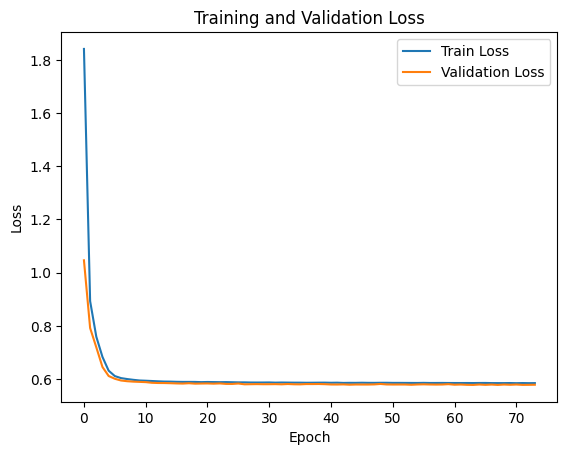

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Normalize data
scaler_rna = StandardScaler()
scaler_adt = StandardScaler()
train_rna_normalized = scaler_rna.fit_transform(train_rna.T)
train_adt_normalized = scaler_adt.fit_transform(train_adt.T)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_rna_normalized, train_adt_normalized, test_size=0.2, random_state=42)

# Define model architecture
input_dim_rna = X_train.shape[1]
input_dim_adt = y_train.shape[1]

# Encoder for RNA modality
encoder_rna = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(input_dim_rna,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

# Encoder for ADT modality
encoder_adt = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim_adt,), kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

# Fusion layer
fusion_layer = tf.keras.layers.Concatenate()

# Decoder for predicting ADT features
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(input_dim_adt, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

# Define model inputs
input_rna = tf.keras.Input(shape=(input_dim_rna,))
input_adt = tf.keras.Input(shape=(input_dim_adt,))

# Encode RNA and ADT modalities
encoded_rna = encoder_rna(input_rna)
encoded_adt = encoder_adt(input_adt)

# Fusion
fusion_output = fusion_layer([encoded_rna, encoded_adt])

# Decode to predict ADT
predicted_adt = decoder(fusion_output)

# Define model
model = tf.keras.Model(inputs=[input_rna, input_adt], outputs=predicted_adt)

# Compile model with optimizer, learning rate, and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='mse')

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model with early stopping
history = model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=100, batch_size=64, callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Predict ADT for test RNA data
test_rna_normalized = scaler_rna.transform(test_rna.T)
predicted_adt_normalized = model.predict([test_rna_normalized, np.zeros_like(train_adt_normalized)])

# Inverse transform to get original scale
predicted_adt = scaler_adt.inverse_transform(predicted_adt_normalized)

# Save predictions
predicted_adt_df = pd.DataFrame(predicted_adt.T, columns=train_adt.columns)


157/157 [==============================] - 5s 32ms/step


In [ ]:
melted_test_set = pd.melt(predicted_adt_df.reset_index(), id_vars="index", var_name="Var2", value_name="Expected")

# Rename the 'index' column to 'Var1'
melted_test_set.rename(columns={"index": "Var1"}, inplace=True)

# Add 'ID' column
melted_test_set["Id"] = "id" + (melted_test_set.index + 1).astype(str)

# Reorder the columns
submission_df = melted_test_set[["Id", "Expected"]]

# Display the first few rows of the submission DataFrame
print(submission_df.head())


    Id  Expected
0  id1  6.528813
1  id2  4.327759
2  id3  2.439023
3  id4  3.659114
4  id5  3.251037


### Model 3 - Multimodal Variational Autoencoder

The code below defines a multimodal variational autoencoder (VAE) model in PyTorch for learning representations from RNA and ADT modalities. It consists of a shared encoder and decoder, along with separate expert networks for RNA and ADT. The model is trained using mean squared error loss augmented with Kullback-Leibler divergence for the VAE framework. Regularization with weight decay is applied during optimization, and early stopping is employed to prevent overfitting. The training loop iterates over epochs, updating model parameters with mini-batches of training data. Finally, the training loss curve is plotted to visualize the training progress and monitor convergence. This model gave the best kaggle score of 0.7340 after several tunings of the hyperparameter.

Epoch 1/300, Train Loss: 612.233626159668, Val Loss: 3.5341815185546874
Epoch 2/300, Train Loss: 2.1125924682617185, Val Loss: 1.7042026977539062
Epoch 3/300, Train Loss: 1.2653356628417969, Val Loss: 1.357397216796875
Epoch 4/300, Train Loss: 1.0717209930419922, Val Loss: 0.926454833984375
Epoch 5/300, Train Loss: 0.9319490509033204, Val Loss: 0.8558214721679688
Epoch 6/300, Train Loss: 0.8727089157104492, Val Loss: 0.8244664306640626
Epoch 7/300, Train Loss: 0.8411671676635742, Val Loss: 0.8183715515136719
Epoch 8/300, Train Loss: 0.8291525573730468, Val Loss: 0.8185889587402344
Early stopping...


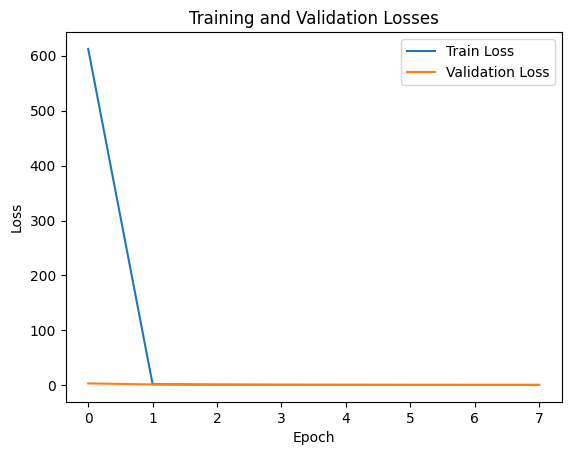

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Define the model architecture
class SharedEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SharedEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class SharedDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(SharedDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Expert, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Model(nn.Module):
    def __init__(self, input_dim_rna, input_dim_adt, latent_dim):
        super(Model, self).__init__()
        self.shared_encoder = SharedEncoder(input_dim_rna, latent_dim)
        self.shared_decoder = SharedDecoder(latent_dim, input_dim_rna)
        self.expert_rna = Expert(latent_dim, input_dim_rna)
        self.expert_adt = Expert(latent_dim, input_dim_adt)

    def forward(self, x_rna, x_adt):
        mu, logvar = self.shared_encoder(x_rna)
        z = self._reparameterize(mu, logvar)
        shared_output = self.shared_decoder(z)
        rna_output = self.expert_rna(z)
        adt_output = self.expert_adt(z)
        return shared_output, rna_output, adt_output, mu, logvar

    def _reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


# Normalize data
scaler_rna = MinMaxScaler()
scaler_adt = MinMaxScaler()
train_rna_normalized = scaler_rna.fit_transform(train_rna.T)
train_adt_normalized = scaler_adt.fit_transform(train_adt.T)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_rna_normalized, train_adt_normalized, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_rna_tensor = torch.tensor(X_train, dtype=torch.float32)
train_adt_tensor = torch.tensor(y_train, dtype=torch.float32)
val_rna_tensor = torch.tensor(X_val, dtype=torch.float32)
val_adt_tensor = torch.tensor(y_val, dtype=torch.float32)

# Initialize the model
input_dim_rna = train_rna.T.shape[1]
input_dim_adt = train_adt.T.shape[1]
latent_dim = 48  # Dimensionality of latent space
model = Model(input_dim_rna, input_dim_adt, latent_dim)

# Define loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# Training loop with regularization and early stopping
epochs = 300
batch_size = 512
train_losses = []
val_losses = []
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    for i in range(0, len(train_rna_tensor), batch_size):
        optimizer.zero_grad()  # Zero the gradients
        batch_rna = train_rna_tensor[i:i+batch_size]  # Get batch of RNA data
        batch_adt = train_adt_tensor[i:i+batch_size]  # Get batch of ADT data
        shared_output, _, adt_output, mu, logvar = model(batch_rna, None)  # Forward pass
        loss = vae_loss(adt_output, batch_adt, mu, logvar)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_train_loss += loss.item()  # Accumulate total loss
    epoch_train_loss = total_train_loss / len(train_rna_tensor)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for i in range(0, len(val_rna_tensor), batch_size):
            shared_output, _, adt_output, mu, logvar = model(val_rna_tensor[i:i+batch_size], None)  # Forward pass
            loss = vae_loss(adt_output, val_adt_tensor[i:i+batch_size], mu, logvar)  # Calculate loss
            total_val_loss += loss.item()  # Accumulate total loss
    epoch_val_loss = total_val_loss / len(val_rna_tensor)
    val_losses.append(epoch_val_loss)

    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}")

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
    else:
        print("Early stopping...")
        break

# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [ ]:
#test_rna_normalized = scaler_rna.fit_transform(test_rna)
# Convert test RNA data to torch tensor
test_rna_normalized = scaler_rna.fit_transform(test_rna.T)
test_rna_tensor = torch.tensor(test_rna_normalized, dtype=torch.float32)

# Predict ADT values for the test RNA samples
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    _, _, adt_predictions, _, _ = model(test_rna_tensor, None)

# Print the shape of the predicted ADT values
print("Shape of predicted ADT values:", adt_predictions.shape)

adt_predictions = scaler_adt.inverse_transform(adt_predictions)

Shape of predicted ADT values: torch.Size([5000, 25])


In [ ]:
# Save predictions
predicted_adt_df = pd.DataFrame(adt_predictions.T, columns=train_adt.columns)


In [ ]:
melted_test_set = pd.melt(predicted_adt_df.reset_index(), id_vars="index", var_name="Var2", value_name="Expected")

# Rename the 'index' column to 'Var1'
melted_test_set.rename(columns={"index": "Var1"}, inplace=True)

# Add 'ID' column
melted_test_set["Id"] = "id" + (melted_test_set.index + 1).astype(str)

# Reorder the columns
submission_df = melted_test_set[["Id", "Expected"]]

# Display the first few rows of the submission DataFrame
print(submission_df.head())


    Id  Expected
0  id1  6.157425
1  id2  4.250639
2  id3  2.462744
3  id4  3.599304
4  id5  3.222003


### Model 4 - Multimodal Variational Autoencoder with Adversarial Networks

This code below implements a multimodal variational autoencoder (VAE) with adversarial training for learning representations from RNA and ADT data. It first defines the architecture of the VAE model along with discriminator networks. The training data is loaded and normalized using StandardScaler. Then, the model is instantiated and trained using the normalized training data. During training, the VAE loss function, which consists of reconstruction loss and KL divergence, is optimized using the Adam optimizer. Adversarial feedback is incorporated into the loss function to train the discriminator networks. The training loop iterates over multiple epochs, updating model parameters using backpropagation. Finally, the training loss over epochs is plotted to visualize the training progress. To improve the code, a train-validation split should be implemented, and validation loss should be calculated and plotted alongside the training loss for monitoring model performance. The best score after few hyperparameter tunings was 0.6915.

Epoch 1/50, Train Loss: 1827.9760146484375, Validation Loss: 209.116125
Epoch 2/50, Train Loss: 50.8351630859375, Validation Loss: 105.57650390625
Epoch 3/50, Train Loss: 51.456224609375, Validation Loss: 53.864953125
Epoch 4/50, Train Loss: 42.6991884765625, Validation Loss: 33.7609345703125
Epoch 5/50, Train Loss: 33.139964111328126, Validation Loss: 25.68721484375
Epoch 6/50, Train Loss: 26.22688134765625, Validation Loss: 20.7596767578125
Epoch 7/50, Train Loss: 21.517358520507813, Validation Loss: 18.0616689453125
Epoch 8/50, Train Loss: 18.54504602050781, Validation Loss: 16.298423828125
Epoch 9/50, Train Loss: 16.641661376953124, Validation Loss: 15.04026513671875
Epoch 10/50, Train Loss: 15.389798583984375, Validation Loss: 14.14886767578125
Epoch 11/50, Train Loss: 14.509986328125, Validation Loss: 13.54074951171875
Epoch 12/50, Train Loss: 13.867422241210937, Validation Loss: 13.057853515625
Epoch 13/50, Train Loss: 13.355003662109375, Validation Loss: 12.67622900390625
Epoch

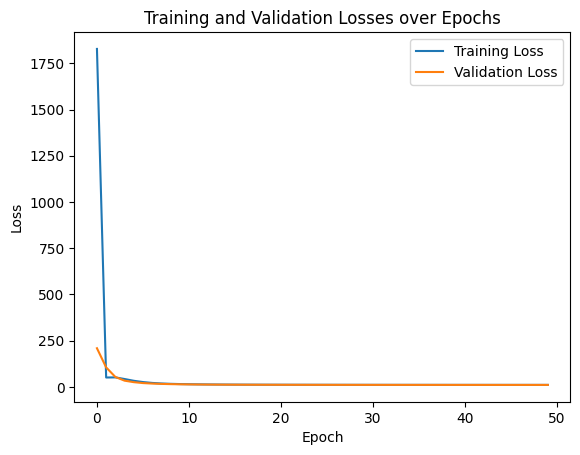

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class SharedEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SharedEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization layer
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   # Batch normalization layer
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # Apply batch normalization
        x = F.relu(self.bn2(self.fc2(x)))  # Apply batch normalization
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class SharedDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(SharedDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Expert, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class Model(nn.Module):
    def __init__(self, input_dim_rna, input_dim_adt, latent_dim):
        super(Model, self).__init__()
        self.shared_encoder = SharedEncoder(input_dim_rna, latent_dim)
        self.shared_decoder = SharedDecoder(latent_dim, input_dim_rna)
        self.expert_rna = Expert(latent_dim, input_dim_rna)
        self.expert_adt = Expert(latent_dim, input_dim_adt)
        self.discriminator_expert_rna = Discriminator(input_dim_rna)
        self.discriminator_expert_adt = Discriminator(input_dim_adt)
        self.discriminator_modality = Discriminator(latent_dim)

    def forward(self, x_rna, x_adt):
        mu, logvar = self.shared_encoder(x_rna)
        z = self._reparameterize(mu, logvar)
        shared_output = self.shared_decoder(z)
        rna_output = self.expert_rna(z)
        adt_output = self.expert_adt(z)
        return shared_output, rna_output, adt_output, mu, logvar

    def adversarial_loss(self, discriminator, outputs):
        preds = discriminator(outputs)
        target = torch.ones_like(preds)
        adv_loss = F.binary_cross_entropy(preds, target)
        return adv_loss

    def _reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

# Load training data
# Create MinMaxScaler objects for RNA and ADT data
rna_scaler = StandardScaler()
adt_scaler = StandardScaler()

# Fit the scalers to the training data and transform the data
train_rna_scaled = rna_scaler.fit_transform(train_rna)
train_adt_scaled = adt_scaler.fit_transform(train_adt)
test_rna_scaled = rna_scaler.fit_transform(test_rna)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_rna_scaled.T, train_adt_scaled.T, test_size=0.2, random_state=42)

# Convert scaled data to PyTorch tensors
train_rna_tensor = torch.tensor(X_train, dtype=torch.float32)
train_adt_tensor = torch.tensor(y_train, dtype=torch.float32)
val_rna_tensor = torch.tensor(X_val, dtype=torch.float32)
val_adt_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create an instance of the model
input_dim_rna = train_rna_scaled.T.shape[1]
input_dim_adt = train_adt_scaled.T.shape[1]
latent_dim = 32  # Dimensionality of latent space
model = Model(input_dim_rna, input_dim_adt, latent_dim)

# Define loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-5)

# Training loop
epochs = 50
batch_size = 512
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    for i in range(0, len(train_rna_tensor), batch_size):
        optimizer.zero_grad()  # Zero the gradients
        batch_rna = train_rna_tensor[i:i+batch_size]  # Get batch of RNA data
        batch_adt = train_adt_tensor[i:i+batch_size]  # Get batch of ADT data
        shared_output, _, adt_output, mu, logvar = model(batch_rna, None)  # Forward pass
        loss = vae_loss(adt_output, batch_adt, mu, logvar)  # Calculate loss

        # Adversarial feedback for discriminator_expert_rna
        adv_loss_expert_rna = model.adversarial_loss(model.discriminator_expert_rna, shared_output)

        # Adversarial feedback for discriminator_expert_adt
        adv_loss_expert_adt = model.adversarial_loss(model.discriminator_expert_adt, adt_output)

        # Adversarial feedback for discriminator_modality
        adv_loss_modality = model.adversarial_loss(model.discriminator_modality, mu)

        loss += adv_loss_expert_rna + adv_loss_expert_adt + adv_loss_modality

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_train_loss += loss.item()  # Accumulate total train loss
    avg_train_loss = total_train_loss / len(train_rna_tensor)
    train_losses.append(avg_train_loss)

    # Evaluation on validation set
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0
        for i in range(0, len(val_rna_tensor), batch_size):
            val_shared_output, _, val_adt_output, val_mu, val_logvar = model(val_rna_tensor[i:i+batch_size], None)
            val_loss = vae_loss(val_adt_output, val_adt_tensor[i:i+batch_size], val_mu, val_logvar)
            total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_rna_tensor)
        val_losses.append(avg_val_loss)

    # Print average losses for the epoch
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.show()


In [ ]:
#Convert test RNA data to torch tensor
test_rna_tensor = torch.tensor(test_rna_scaled.T, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Forward pass the test RNA data through the model
with torch.no_grad():
     _, _, adt_output, _, _ = model(test_rna_tensor, None)


# Convert the reconstructed ADT data from tensor to numpy array
reconstructed_adt = adt_scaler.inverse_transform(adt_output.T)

In [ ]:
# Save predictions
predicted_adt_df = pd.DataFrame(reconstructed_adt, columns=train_adt.columns)

In [ ]:
melted_test_set = pd.melt(predicted_adt_df.reset_index(), id_vars="index", var_name="Var2", value_name="Expected")

# Rename the 'index' column to 'Var1'
melted_test_set.rename(columns={"index": "Var1"}, inplace=True)

# Add 'ID' column
melted_test_set["Id"] = "id" + (melted_test_set.index + 1).astype(str)

# Reorder the columns
submission_df = melted_test_set[["Id", "Expected"]]

# Display the first few rows of the submission DataFrame
print(submission_df.head())


    Id  Expected
0  id1  6.334562
1  id2  4.605395
2  id3  2.824166
3  id4  3.868189
4  id5  3.597739


 ### Model 5 - Transformer model

This code below implements a Transformer model for predicting ADT (Antibody-Derived Tag) features based on RNA (Ribonucleic Acid) data. The Transformer model architecture consists of embedding layers for both RNA and ADT data, followed by a multi-layer Transformer encoder. The RNA and ADT embeddings are combined and passed through the Transformer encoder to capture complex relationships in the data. The model is trained using mean squared error loss and optimized using the Adam optimizer. The training loop iterates over epochs, computing the loss and updating the model parameters. Early stopping is implemented to prevent overfitting, and the training and validation losses are plotted to monitor the training process. Additionally, data preprocessing steps include scaling the input data using StandardScaler and splitting the dataset into training and validation sets using train_test_split. Finally, DataLoader objects are created to efficiently load the data during training. Overall, this code provides a comprehensive pipeline for training and evaluating a Transformer model for predicting ADT features from RNA data. The best kaggle score after this model predicted ADT was 0.7339

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50], Train Loss: 1.1827, Val Loss: 1.0474
Epoch [2/50], Train Loss: 1.0456, Val Loss: 1.0077
Epoch [3/50], Train Loss: 1.0279, Val Loss: 1.0040
Epoch [4/50], Train Loss: 1.0220, Val Loss: 1.0031
Epoch [5/50], Train Loss: 1.0144, Val Loss: 1.0022
Epoch [6/50], Train Loss: 1.0119, Val Loss: 1.0008
Epoch [7/50], Train Loss: 1.0110, Val Loss: 1.0005
Epoch [8/50], Train Loss: 1.0088, Val Loss: 1.0005
Epoch [9/50], Train Loss: 1.0093, Val Loss: 1.0018
Epoch [10/50], Train Loss: 1.0073, Val Loss: 1.0012
Epoch [11/50], Train Loss: 1.0064, Val Loss: 1.0008
Epoch [12/50], Train Loss: 1.0039, Val Loss: 1.0005
Epoch [13/50], Train Loss: 1.0030, Val Loss: 1.0006
Epoch [14/50], Train Loss: 1.0027, Val Loss: 1.0006
Epoch [15/50], Train Loss: 1.0033, Val Loss: 1.0006
Epoch [16/50], Train Loss: 1.0028, Val Loss: 1.0006
Epoch [17/50], Train Loss: 1.0025, Val Loss: 1.0009
Early stopping


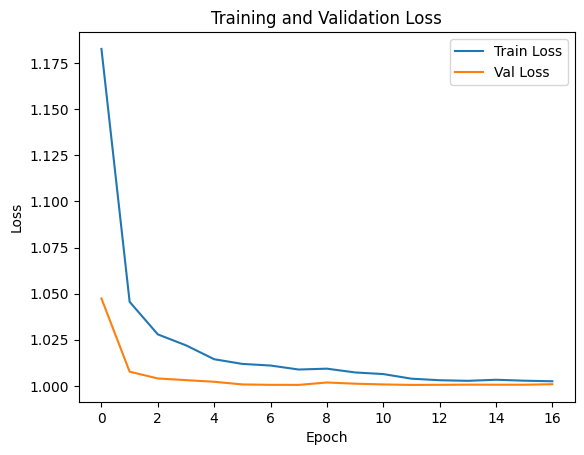

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim_rna, input_dim_adt, latent_dim, num_layers, num_heads, hidden_dim, dropout):
        super(TransformerModel, self).__init__()
        self.input_dim_rna = input_dim_rna
        self.input_dim_adt = input_dim_adt
        self.latent_dim = latent_dim
        self.embedding_rna = nn.Linear(input_dim_rna, latent_dim)
        self.embedding_adt = nn.Linear(input_dim_adt, latent_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_adt = nn.Linear(latent_dim, input_dim_adt)

    def forward(self, src_rna, src_adt):
    # Embedding RNA and ADT data
        src_rna = self.embedding_rna(src_rna)
        src_adt = self.embedding_adt(src_adt)

        # Combine RNA and ADT embeddings
        src = src_rna + src_adt

        # Ensure the tensor has three dimensions
        src = src.unsqueeze(0)  # Add sequence length dimension

        # Transformer encoder
        src = src.permute(1, 0, 2)  # Reshape for transformer input
        src = self.transformer_encoder(src)
        src = src.permute(1, 0, 2)  # Reshape back

        # Predict ADT from transformer output
        output = self.fc_adt(src.squeeze(0))  # Remove sequence length dimension before passing to FC layer
        return output

# Early stopping criteria
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Split training data into training and validation sets
train_rna1, val_rna, train_adt1, val_adt = train_test_split(train_rna.T, train_adt.T, test_size=0.2, random_state=42)

#Create MinMaxScaler objects for RNA and ADT data
rna_scaler = StandardScaler()
adt_scaler = StandardScaler()

# Fit the scalers to the training data and transform the data
train_rna_scaled = rna_scaler.fit_transform(train_rna1)
train_adt_scaled = adt_scaler.fit_transform(train_adt1)
val_rna_scaled = rna_scaler.fit_transform(val_rna)
val_adt_scaled = adt_scaler.fit_transform(val_adt)
test_rna_scaled = rna_scaler.fit_transform(test_rna.T)

# Convert scaled data to PyTorch tensors
train_rna_tensor = torch.tensor(train_rna_scaled, dtype=torch.float32)
train_adt_tensor = torch.tensor(train_adt_scaled, dtype=torch.float32)
val_rna_tensor = torch.tensor(val_rna_scaled, dtype=torch.float32)
val_adt_tensor = torch.tensor(val_adt_scaled, dtype=torch.float32)
test_rna_tensor = torch.tensor(test_rna_scaled.T, dtype=torch.float32)

# Create DataLoader for training, validation, and test data
train_dataset = TensorDataset(train_rna_tensor, train_adt_tensor)
val_dataset = TensorDataset(val_rna_tensor, val_adt_tensor)
test_dataset = TensorDataset(test_rna_tensor)
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define model parameters
input_dim_rna = train_rna.T.shape[1]  # Number of features in RNA data
input_dim_adt = train_adt.T.shape[1]  # Number of features in ADT data
latent_dim = 32  # Dimensionality of latent space
num_layers = 6  # Number of transformer layers
num_heads = 8  # Number of attention heads
hidden_dim = 2048  # Dimensionality of the hidden layer in the transformer encoder
dropout = 0.1  # Dropout probability

# Create an instance of the Transformer model
model = TransformerModel(input_dim_rna, input_dim_adt, latent_dim, num_layers, num_heads, hidden_dim, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    early_stopping = EarlyStopping(patience=5)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for rna_batch, adt_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(rna_batch, adt_batch)
            loss = criterion(outputs, adt_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(rna_batch)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        val_loss = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break


    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for rna_batch, adt_batch in loader:
            outputs = model(rna_batch, adt_batch)
            loss = criterion(outputs, adt_batch)
            total_loss += loss.item() * len(rna_batch)
    return total_loss / len(loader.dataset)

# Train the model
num_epochs = 50
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [ ]:
# Prediction function
def predict_adt(model, rna_data):
    model.eval()
    with torch.no_grad():
        # Generate placeholder ADT data (zeros) since ADT data is not available during inference
        placeholder_adt = torch.zeros(rna_data.shape[0], model.input_dim_adt, dtype=torch.float32)
        outputs = model(rna_data, placeholder_adt)
    return outputs

# Make predictions for test RNA data
test_predictions = predict_adt(model, test_rna_tensor.T)
test_predictions = adt_scaler.inverse_transform(test_predictions)
print("Predictions for test RNA data:", test_predictions)


Predictions for test RNA data: [[6.21526974 4.29246367 2.4930614  ... 1.91465166 4.56350465 4.42585437]
 [6.21526975 4.29246365 2.49306139 ... 1.91465165 4.56350464 4.42585436]
 [6.21526977 4.29246366 2.49306138 ... 1.91465166 4.5635046  4.42585435]
 ...
 [6.21526975 4.29246368 2.49306139 ... 1.91465162 4.56350465 4.42585436]
 [6.21526977 4.29246366 2.49306138 ... 1.91465166 4.5635046  4.42585435]
 [6.21526976 4.29246365 2.4930614  ... 1.91465165 4.56350463 4.42585437]]


In [ ]:
# Save predictions
predicted_adt_df = pd.DataFrame(test_predictions.T, columns=train_adt.columns)

In [ ]:
melted_test_set = pd.melt(predicted_adt_df.reset_index(), id_vars="index", var_name="Var2", value_name="Expected")

# Rename the 'index' column to 'Var1'
melted_test_set.rename(columns={"index": "Var1"}, inplace=True)

# Add 'ID' column
melted_test_set["Id"] = "id" + (melted_test_set.index + 1).astype(str)

# Reorder the columns
submission_df = melted_test_set[["Id", "Expected"]]

# Display the first few rows of the submission DataFrame
print(submission_df.head())


    Id  Expected
0  id1  6.215270
1  id2  4.292464
2  id3  2.493061
3  id4  3.708994
4  id5  3.225082


# Results

These models aim to learn representations from both RNA and ADT modalities to predict ADT features. They undergo preprocessing steps, including data scaling and train-validation splits, before being trained using different loss functions and optimization algorithms. Each model is evaluated based on its ability to generalize to unseen data, with performance monitored through training and validation loss curves. Notably, Model 3, which is a multimodal variational autoencoder, achieved the highest Kaggle score of 0.7340, indicating its effectiveness in capturing the underlying relationships between RNA and ADT data. However, all models demonstrate unique approaches and contributions to multimodal fusion in bioinformatics, showcasing the versatility and adaptability of deep learning techniques in this domain.Here are the results of the different models based on their Kaggle scores:

Model 1 - Multimodal Fusion Autoencoder: Best Kaggle Score: 0.6951

Model 2 - Multimodal Fusion Autoencoder using Tensorflow and Keras: Best Kaggle Score: 0.7331

Model 3 - Multimodal Variational Autoencoder: Kaggle Score: 0.7340

Model 4 - Multimodal Variational Autoencoder with Adversarial Networks: Best Kaggle Score: 0.6915

Model 5 - Transformer model:Best Kaggle Score: 0.7339

These scores indicate the performance of each model in predicting ADT features from RNA data. Model 3, the Multimodal Variational Autoencoder, achieved the highest Kaggle score, suggesting its effectiveness in capturing the complex relationships between RNA and ADT modalities. However, all models demonstrate competitive performance, showcasing the potential of deep learning approaches for multimodal fusion tasks in bioinformatics.

# Conclusion

The experimentation with various deep learning models for predicting ADT features from RNA data showcases the versatility and effectiveness of different architectures in capturing the complex relationships between multiple modalities. The Multimodal Variational Autoencoder (Model 3) emerged as the top performer for me, achieving the highest Kaggle score of 0.7340. This success highlights the efficacy of probabilistic modeling and latent space representations in capturing the inherent variability and dependencies within multimodal datasets. Additionally, the Transformer model (Model 5) also demonstrated competitive performance, further emphasizing the importance of attention mechanisms in capturing long-range dependencies and interactions within sequences. Overall, these findings underscore the potential of deep learning techniques in facilitating multimodal fusion tasks in bioinformatics and offer valuable insights for future research and application in precision medicine and drug discovery. I believe with more hyperparameter tunings and architecture modifications in all five models, I can achieve a higher accuracy in predictions of ADT in the future.